## HIGH DIMENSIONAL ANALYSIS


*   **Programing Exercise: 02**
*   **Name: Đinh Anh Huy**
*   **Student code       : 18110103**




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
%matplotlib inline

**Apply Linear Discriminant Analysis algorithm on the Iris flower dataset.**

Thuật toán LDA được thực hiện thông qua các bước:

1.   Chuẩn hoá dữ liệu (d-chiều).
2.   Với mỗi class, tính vectơ trung bình (d-chiều).
3.   Xây dựng between-class scatter matrix $\textbf{S}_B$ và within-class scatter matrix $\textbf{S}_W$.

Trong đó
$$ \textbf{S}_W = \displaystyle\sum_{i=1}^c\textbf{S}_i$$

$$ \textbf{S}_B = \displaystyle\sum_{i=1}^cn_i(\textbf{m}_i-\textbf{m})(\textbf{m}_i-\textbf{m})^T$$

với $\textbf{S}_i = \displaystyle\sum_{x\in D_i}^c(\textbf{x}-\textbf{m}_i)(\textbf{x}-\textbf{m}_i)^T$ là scatter matrix matrix của class thứ i, $\textbf{m}$ là overall mean và $\textbf{m}_i$ là sample mean của class $i$.
4.   Tìm các vectơ riêng và trị riêng của ma trận $\textbf{S}_W^{-1}\textbf{S}_B$.
5.   Sắp xếp các trị riêng theo thứ tự giảm dần.
6.   Chọn k vectơ riêng đầu tiên ứng với k trị riêng lớn nhất trong bộ trị riêng đã sắp xếp ở trên (k < d).
7.   Xây dựng ma trận chiếu $\textbf{W}\in M_{k\times d}(\mathbf{R})$ từ các vectơ riêng ở trên.
8.   Tìm hình chiếu $Y$ của ma trận dữ liệu X trong không gian mới sinh bởi ma trận $\textbf{W}$, $Y=\textbf{W}X$.

Từ ý tưởng các bước thực hiện như trên, ta xây dựng `class MyLDA` có

* *Tham số*:
  * `n_components`: Số lượng vectơ thành phần chính, mặc định là `None`.
* *Thuộc tính*:
  * `explained_variance_ratio_`: Phần trăm phương sai được giải thích theo từng thành phần đã chọn. Tổng tất cả các tỷ lệ sẽ bằng 1.
  * `eigenpairs_`: Danh sách các bộ có thứ tự, trong đó mỗi bộ là 1 cặp (trị riêng, vectơ riêng tương ứng).
  * `weights_`: Ma trận chiếu $\textbf{W}$.
  * `means_`: Bộ các vectơ trung bình theo từng class.
  * `classes_`: Giá trị unique của các class trong cột target.
* *Phương thức*:
  * `_calc_mean_(X, y)`: Tính giá trị cho `means_`.
  * `_calc_within_class_scatter_matrix(X, y)`: Tính ma trận $\textbf{S}_W$.
  * `_calc_between_class_scatter_matrix(X, y)`: Tính ma trận $\textbf{S}_B$.
  * `fit(X, y)`: Áp dụng thuật toán LDA với X, y.
  * `fit_transform(X, y)`: Áp dụng thuật toán PCA với X, y và giảm số chiều trên X.
  * `transform(X)`: Áp dụng giảm số chiều trên X với dữ liệu thu được từ phương thức `fit`.

  Input của các phương thức bắt buộc phải là dữ liệu dạng số.


In [3]:
class MyLDA:
  def __init__(self, n_components=None):
    self.n_components = n_components
    self.weights_ = None
    self.explained_variance_ratio_ = None
    self.means_ = []
    self.classes_ = None
    self.eigenpairs_ = None

  def _calc_mean_(self, X, y):
    for label in self.classes_:
      self.means_.append(np.mean(X[y==label], axis=0))
    self.means_ = np.array(self.means_)
  
  def _calc_within_class_scatter_matrix(self, X, y):
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for group in self.classes_:
      Sw += np.cov(X[y == group].T)
    self.Sw = Sw

  def _calc_between_class_scatter_matrix(self, X, y):
    no_samples = np.bincount(y) # number of samples for given class
    mean_overall = np.mean(X, axis=0)

    Sb = np.zeros((X.shape[1], X.shape[1]))
    for c in self.classes_:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)

        n_c = X_c.shape[0]
        mean_diff = (mean_c - mean_overall).reshape(X.shape[1], 1)
        Sb += n_c * (mean_diff).dot(mean_diff.T)

    self.Sb = Sb

  def fit(self, X, y):
    self.classes_ = np.unique(y)
    n_samples = X.shape[0]
    n_classes = len(self.classes_)

    # Maximum number of components no matter what n_components is specified:
    max_components = min(n_classes - 1, X.shape[1])
    if self.n_components is None:
        self._max_components = max_components
    else:
        if self.n_components > max_components:
            raise ValueError("n_components cannot be larger than min(n_features, n_classes - 1).")
        self._max_components = self.n_components

    # For each class, compute mean vector
    self._calc_mean_(X, y)
    
    # Construct the within-class scatter matrix Sw and between-class scatter matrix Sb
    self._calc_within_class_scatter_matrix(X, y)
    self._calc_between_class_scatter_matrix(X, y)

    # Compute the eigenvectors and corresponding eigenvalues of the matrix Sw^(-1)Sb
    eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(self.Sw).dot(self.Sb))
    
    # Sort paires (eigenvalue, eigenvector) in descending order
    eigenpairs = [(np.abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
    eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

    # Select a subset from the rearranged eigenvalues vector
    self.eigenpairs_ = eigenpairs[:self._max_components]
    
    # Construct weight matrix from above subset
    self.components_ = [eigenvec for (_, eigenvec) in self.eigenpairs_]
    # self.weights_ = np.array([eigenvec.T for eigenvec in self.components_])
    self.weights_ = np.real(np.array([eigenpairs[i][1] for i in range(self._max_components)]).T)

    # Calculate percentage of cariance explained by each of the selected components
    eigenvals = [eigenval for (eigenval, _) in self.eigenpairs_]
    
    self.explained_variance_ratio_ = eigenvals / np.sum(eigenvals)

  def transform(self, X):
    return X.dot(self.weights_)

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [12]:
data, target = load_iris(return_X_y=True)
df = pd.DataFrame(data)
df.columns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
# Normalize data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

In [11]:
# Implement LDA 
lda = MyLDA(n_components=2)
lda.fit(data, target)
data_trans = lda.transform(data)
lda.explained_variance_ratio_
lda.means_

array([[5.006, 3.428, 1.462, 0.246],
       [5.936, 2.77 , 4.26 , 1.326],
       [6.588, 2.974, 5.552, 2.026]])

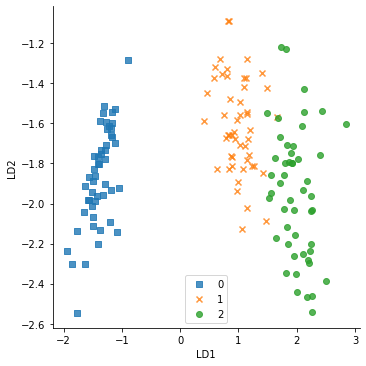

In [6]:
# Plot transformed features in LDA subspace 
df = pd.DataFrame(data_trans)
df['class'] = target
df.columns = ["LD1", "LD2", "class"]

markers = ['s', 'x','o']
sns.lmplot(x="LD1", y="LD2", data=df, markers=markers,fit_reg=False, hue='class', legend=False)
plt.legend(loc='lower center')
plt.show()

**Implement LDA with scikit-learn library.**

In [7]:
# Implement LDA with scikit-learn library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_skl = LDA(n_components=2, solver='eigen').fit(data, target)
data_transform_skl = lda_skl.transform(data)
lda_skl.explained_variance_ratio_

array([0.9912126, 0.0087874])

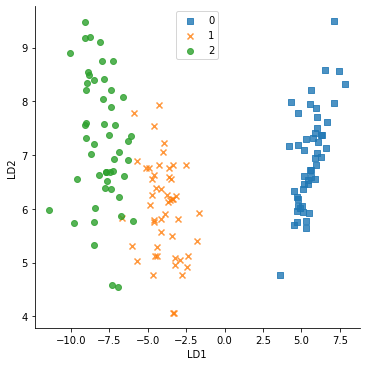

In [8]:
# Plot transformed features in LDA subspace
df_skl = pd.DataFrame(data_transform_skl)
df_skl['class'] = target
df_skl.columns = ["LD1", "LD2", "class"]

markers = ['s', 'x','o']
sns.lmplot(x="LD1", y="LD2", data=df_skl, markers=markers, fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper center')
plt.show()

**Make a
comparison between LDA and PCA projected samples.**

In [9]:
# Implement PCA with scikit-learn library
from sklearn.decomposition import PCA
pca_skl = PCA(n_components=2)
data_pca = pca_skl.fit_transform(data)
pca_skl.explained_variance_ratio_

array([0.92461872, 0.05306648])

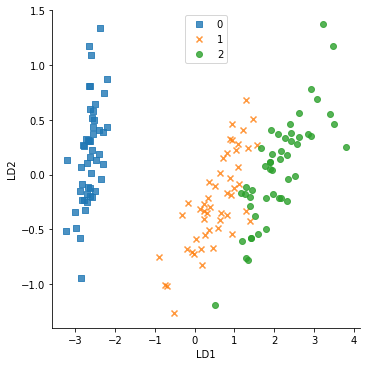

In [10]:
# Plot transformed features in LDA subspace
df_skl = pd.DataFrame(data_pca)
df_skl['class'] = target
df_skl.columns = ["LD1", "LD2", "class"]

markers = ['s', 'x','o']
sns.lmplot(x="LD1", y="LD2", data=df_skl, markers=markers, fit_reg=False, hue='class', legend=False)
plt.legend(loc='upper center')
plt.show()

Dựa vào các gía trị `explained_variance_ratio_` ta có thể thấy rằng:
* Dữ liệu sau khi dimension reduction bằng thuật toán LDA được giải thích bằng 2 pricipal components (PC) theo tỉ lệ lần lượt là $[0.9912126, 0.0087874]$. PC1 giải thích đến 99.1% thông tin dữ liệu và PC2 giải thích được 0.88%.
* Tỉ lệ giải thích của các PC sau khi PCA là $[0.92461872, 0.05306648]$.

Ta có nhận xét sau:
* Thuật toán LDA cho ra kết quả tốt hơn so với PCA khi dữ liệu sau khi transform lưu giữ đến hơn 99% lượng thông tin của dữ liệu ban đầu, trong khi PCA chỉ giữa lại được tổng cộng hơn 97%. 
* Dựa vào scatter plot dữ liệu sau khi transform, ta có thể thấy thuật toán LDA cho ra kết quả các lớp được phân ra gần như tách biệt, khi chiếu xuống PC1, ta gần như nhìn thấy rõ 3 class tách biệt nhau. Trong khi với thuật toán PCA thì class 1 và 2 vẫn còn nhiều giá trị vị chồng lẫn lên nhau, khi chiếu lên PC1 thì class 1 và 2 bị chồng chéo nhau khó phân biệt.